In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import sys, os, pathlib
import numpy as np
import torch

import warp as wp
wp.config.quiet = True
wp.set_device('cpu')

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [31]:
!nvidia-smi

Wed Jan 28 12:33:17 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:61:00.0 Off |                  Off |
| 30%   26C    P8             17W /  300W |   40360MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [32]:
config = project.core.fileio.load_config('2026-01-15_config.yaml')

config['dataset']['examples']['subjects'] = 'one_subject.csv'
#config['dataset']['examples']['subjects'] = 'ten_subjects.csv'
#config['dataset']['examples']['subjects'] = '2026-01-26_preprocessed.csv'

config['dataset']

Loading 2026-01-15_config.yaml


{'name': 'ShapeNet',
 'root': '/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem',
 'examples': {'subjects': 'one_subject.csv', 'variant': '2026-01-15'},
 'metadata': {'parse_metadata': True,
  'unit_policy': 'prefer_metadata',
  'default_unit': 0.01},
 'selectors': {'material_mask': 'uniform-seed'}}

In [33]:
examples = project.api.get_examples(config['dataset'])
len(examples)

Gathering examples


1

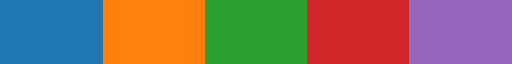

In [34]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
n_labels = 5
colors = plt.get_cmap('tab10').colors
cmap = ListedColormap(colors[:n_labels])
cmap.set_under('white')
cmap.set_over('black')
cmap.set_bad('black')
cmap

Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_uniform-seed_elastic.nii.gz


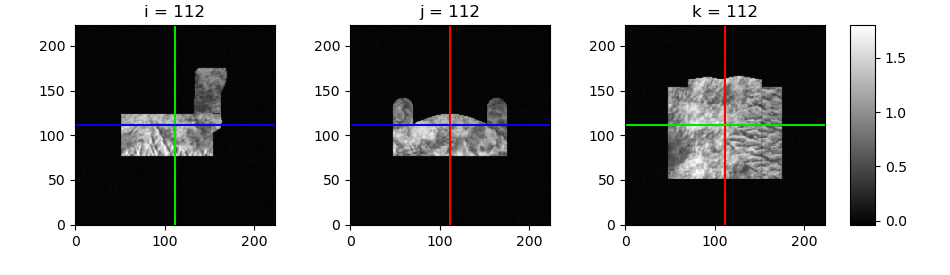

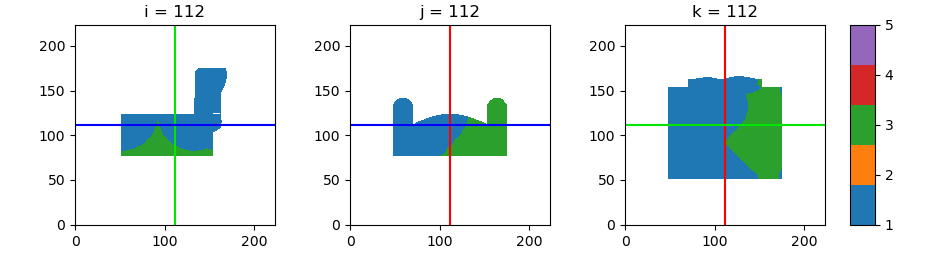

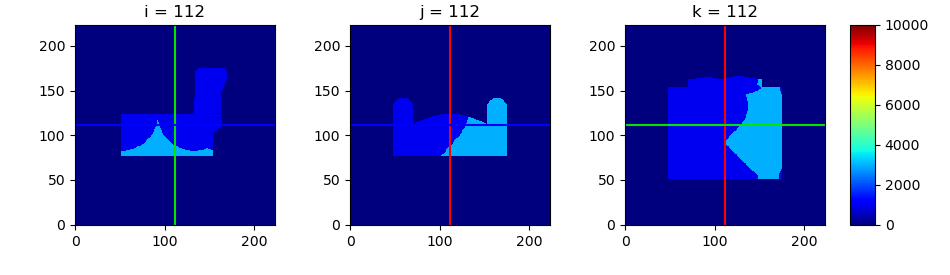

In [35]:
import project.visual.matplotlib

ex = examples[0]
image = project.core.fileio.load_nibabel(ex.paths['input_image'])
project.visual.matplotlib.SliceViewer(image.get_fdata(), cmap='gray')

mask = project.core.fileio.load_nibabel(ex.paths['material_mask'])
project.visual.matplotlib.SliceViewer(mask.get_fdata(), cmap=cmap, vmin=1, vmax=5)

E_true = project.core.fileio.load_nibabel(ex.paths['elastic_field'])
project.visual.matplotlib.SliceViewer(E_true.get_fdata(), cmap='jet', vmin=0, vmax=1e4)

## train_config = config['training'].copy()
train_config['model']['param_space'] = 'log'
train_config['model']['bounds_mode'] = 'none'
train_config['model']['output_shift'] = 3.0
train_config['model']['output_scale'] = 0.1
train_config['model']['input_shift'] = 0.0
train_config['trainer']['supervised'] = False
train_config['optimizer']['lr'] = 1e-4
train_config['physics_adapter']['rho_known'] = True
project.core.utils.pprint(train_config, 2, 100)

In [101]:
import project.training
split_kws = train_config['split']
if len(examples) > 1:
    train_ex, test_ex, val_ex = project.training.split_on_metadata(examples, **split_kws)
else:
    train_ex = test_ex = val_ex = examples

len(train_ex), len(test_ex), len(val_ex)

(1, 1, 1)

In [102]:
import project.datasets.torch
cache_data = False
train_set = project.datasets.torch.TorchDataset(train_ex, cache=cache_data)
test_set = project.datasets.torch.TorchDataset(test_ex, cache=cache_data)
val_set = project.datasets.torch.TorchDataset(val_ex, cache=cache_data)
collate_fn = project.datasets.torch.collate_fn

In [103]:
loader_kws = train_config['loader']
train_loader = torch.utils.data.DataLoader(train_set, collate_fn=collate_fn, **loader_kws)
test_loader = torch.utils.data.DataLoader(test_set, collate_fn=collate_fn, **loader_kws)
val_loader = torch.utils.data.DataLoader(val_set, collate_fn=collate_fn, **loader_kws)

In [112]:
model_kws = train_config['model'].copy()
model_kws['conv_channels'] = 16
model_kws['n_enc_blocks'] = 5
model_kws['n_conv_units'] = 1
model_kws['n_init_units'] = None
model_kws['upsample_mode'] = 'trilinear'
model_kws

{'_class': 'UNet3D',
 'conv_channels': 16,
 'n_enc_blocks': 5,
 'n_conv_units': 1,
 'n_init_units': None,
 'kernel_size': 3,
 'relu_leak': 0.01,
 'norm_type': 'group',
 'num_groups': 8,
 'pooling_type': 'max',
 'upsample_mode': 'trilinear',
 'param_space': 'log',
 'input_shift': 0.0,
 'input_scale': 1.0,
 'output_shift': 3.0,
 'output_scale': 0.1,
 'bounds_mode': 'none',
 'lower_bound': 1.0,
 'upper_bound': 6.0}

In [113]:
import project.models
model_cls = getattr(project.models, model_kws.pop('_class'))
model = model_cls(in_channels=1, out_channels=1, **model_kws)
project.models.count_params(model)

encoder.level0.conv_block.unit0.conv.weight        432	(16, 1, 3, 3, 3)
encoder.level0.conv_block.unit0.norm.weight        16	(16,)
encoder.level0.conv_block.unit0.norm.bias          16	(16,)
encoder.level1.conv_block.unit0.conv.weight        13824	(32, 16, 3, 3, 3)
encoder.level1.conv_block.unit0.norm.weight        32	(32,)
encoder.level1.conv_block.unit0.norm.bias          32	(32,)
encoder.level2.conv_block.unit0.conv.weight        55296	(64, 32, 3, 3, 3)
encoder.level2.conv_block.unit0.norm.weight        64	(64,)
encoder.level2.conv_block.unit0.norm.bias          64	(64,)
encoder.level3.conv_block.unit0.conv.weight        221184	(128, 64, 3, 3, 3)
encoder.level3.conv_block.unit0.norm.weight        128	(128,)
encoder.level3.conv_block.unit0.norm.bias          128	(128,)
encoder.level4.conv_block.unit0.conv.weight        884736	(256, 128, 3, 3, 3)
encoder.level4.conv_block.unit0.norm.weight        256	(256,)
encoder.level4.conv_block.unit0.norm.bias          256	(256,)
decoder.level3.

2939521

In [114]:
import project.physics
cache_context = True
pde_solver_kws = train_config['pde_solver'].copy()
pde_solver_cls = pde_solver_kws.pop('_class')
physics_adapter_kws = train_config['physics_adapter'].copy()
physics_adapter = project.physics.PhysicsAdapter(
    pde_solver_cls=pde_solver_cls, cache=cache_context, **physics_adapter_kws
)
physics_adapter

In [115]:
optimizer_kws = train_config['optimizer'].copy()
optimizer_cls = getattr(torch.optim, optimizer_kws.pop('_class'))
optimizer = optimizer_cls(model.parameters(), **optimizer_kws)

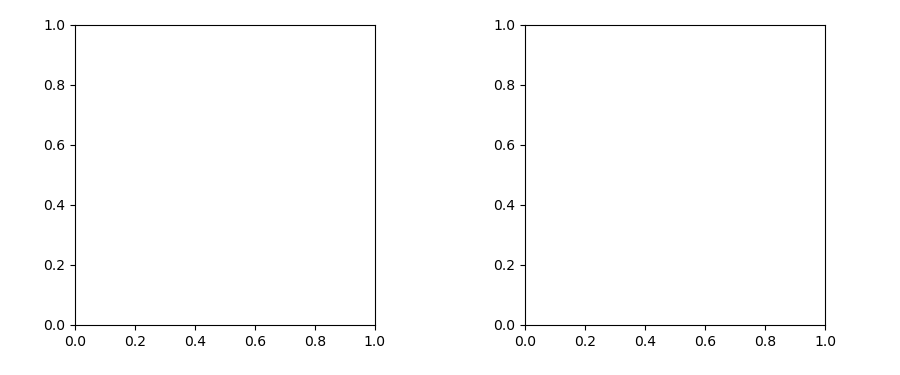

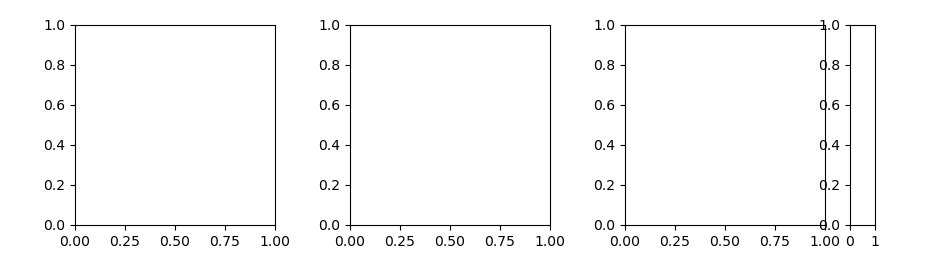

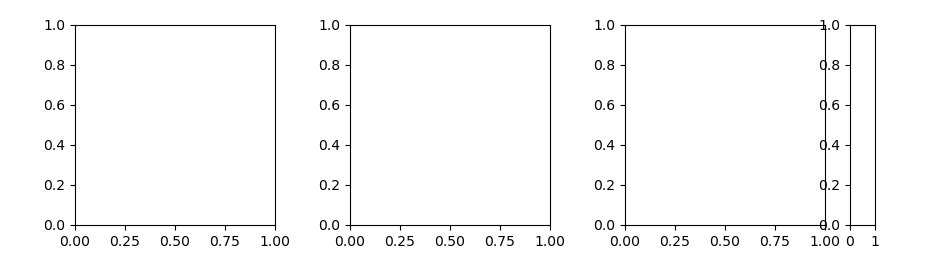

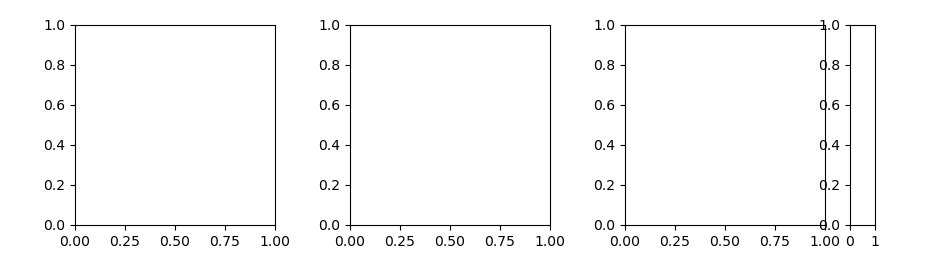

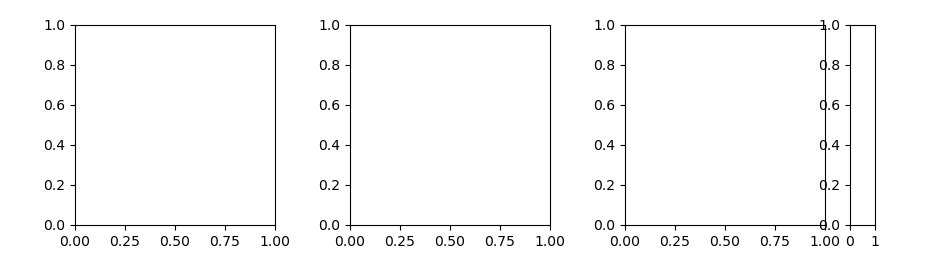

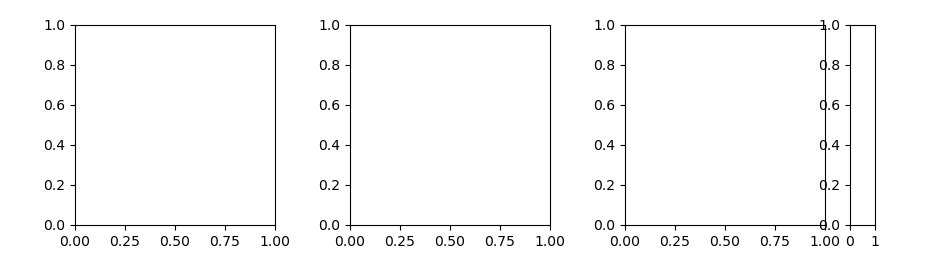

In [116]:
%autoreload
import project.training
import project.evaluation

trainer_kws = train_config['trainer'].copy()
supervised = trainer_kws.pop('supervised', False)

trainer = project.training.Trainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    test_loader=test_loader,
    val_loader=val_loader,
    callbacks=[
        project.evaluation.LoggerCallback(),
        project.evaluation.PlotterCallback(),
        project.evaluation.ViewerCallback(),
        project.evaluation.EvaluatorCallback()
    ],
    physics_adapter=physics_adapter,
    supervised=supervised,
    device='cuda'
)

In [117]:
#trainer.load_state(epoch=20)
trainer.train(num_epochs=100, val_every=0)

Start training loop
===== Epoch 0 =====
Saving checkpoints/checkpoint00000.pt
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/meshes/mask_regions_uniform-seed_image_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_uniform-seed_elastic.nii.gz
[Epoch 0 | Train batch 0/1] loss = 9.0398e-01 | time = 10.7134s | memory = 5285 / 19212 / 46492 MiB


/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/evaluation.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()
/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/visual/matplotlib.py:99: UserWarning: Adding colorbar to a different Figure <Figure size 1662.5x481.25 with 4 Axes> than <Figure size 1662.5x481.25 with 4 Axes> which fig.colorbar is called on.
  plt.colorbar(self.im_k, cax=self.cbar_ax)


===== Epoch 1 =====
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/meshes/mask_regions_uniform-seed_image_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/fields/mask_regions_uniform-seed_elastic.nii.gz
[Epoch 1 | Train batch 0/1] loss = 2.0816e-01 | time = 0.4183s | memory = 5285 / 19238 / 46492 MiB
===== Epoch 2 =====
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/100f39dce7690f59efb94709f30ce0d2/images/mask_regions_uniform-seed_image.nii.gz
Loading /ocean/projects/asc17002

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/evaluation.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()


Saving outputs/example_metrics.csv
Saving outputs/material_metrics.csv
Test metrics @ epoch 100: 
   epoch phase  batch  step      loss                               subject  \
0    100  test      0   100  0.002068  wss.100f39dce7690f59efb94709f30ce0d2   

   num_voxels   E_vox.mean   E_vox.rms  E_vox.rmse  ...  E_cell.scorr  \
0      778627  1881.928667  2138.73038  595.332749  ...      0.751622   

   u_cell.mean  u_cell.rms  u_cell.rmse  u_cell.nrmse  u_cell.srmse  \
0     0.034633    0.043012     0.001863      0.043716      0.072927   

   u_cell.pcorr  u_cell.scorr  res_cell.mean  res_cell.rms  
0       0.99875      0.995174        0.43544      0.805807  

[1 rows x 39 columns]


In [ ]:
import project.visual.matplotlib
import matplotlib.pyplot as plt

def colormap(name, n=None, under=None):
    cmap = plt.get_cmap('jet', n)
    if under:
        cmap.set_under(under)
    return cmap

mm = mask[0][0].detach().cpu().numpy()
im = image[0][0].detach().cpu().numpy()
Ep = E_pred[0][0].detach().cpu().numpy()
Et = E_true[0][0].detach().cpu().numpy()

_ = project.visual.matplotlib.show_image_slices(mm, cmap=colormap('jet', 9, under='white'), clim=(1,9), colors='cmy')
_ = project.visual.matplotlib.show_image_slices(im, cmap='gray', clim=(0,1))
_ = project.visual.matplotlib.show_image_slices(Ep, cmap=colormap('jet'), clim=(0,1e4), colors='cmy')
_ = project.visual.matplotlib.show_image_slices(Et, cmap=colormap('jet'), clim=(0,1e4), colors='cmy')

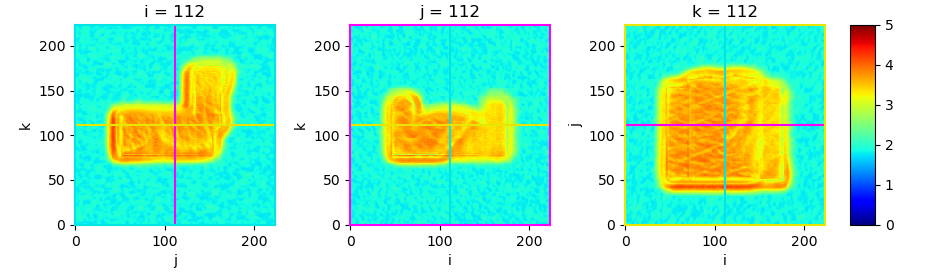

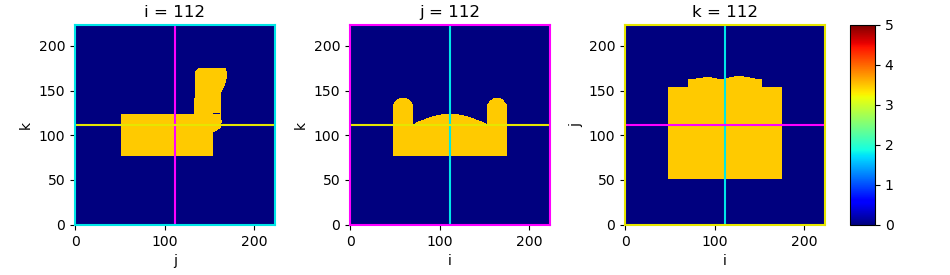

In [195]:
def postprocess(x, lo, hi, eps=1e-5):
    x = np.asarray(x)
    x = np.maximum(x, eps)
    x = np.log10(x)
    x = np.clip(x, lo, hi)
    return x

lo, hi = (0, 5)
n_bins = 500

pp = postprocess(Ep, lo, hi)
pt = postprocess(Et, lo, hi)

cmap = colormap('jet', n_bins, under='black')

_ = project.visual.matplotlib.show_image_slices(pp, clim=(lo, hi), cmap=cmap, colors='cmy')
_ = project.visual.matplotlib.show_image_slices(pt, clim=(lo, hi), cmap=cmap, colors='cmy')

10.0


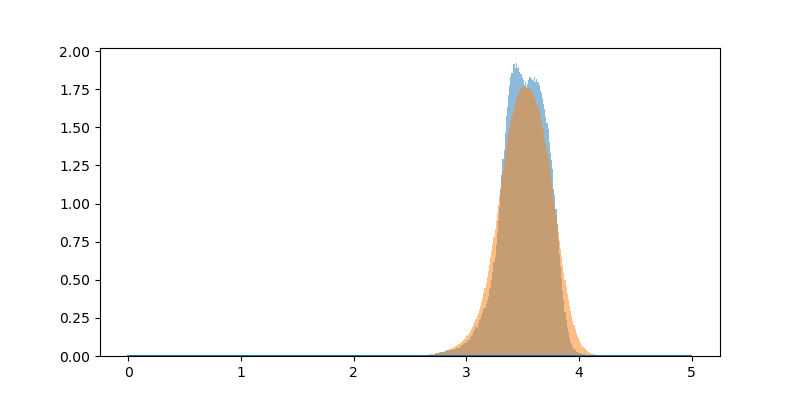

In [251]:
sigma_w = 0.1
spacing = (hi - lo) / n_bins
sigma = sigma_w / spacing
print(sigma)

hist, edges = np.histogram(pp[mm>0], bins=np.linspace(lo, hi, n_bins + 1), density=True)
dens = scipy.ndimage.gaussian_filter1d(hist, sigma=sigma, mode='nearest')

import sklearn
clustering = sklearn.cluster.AgglomerativeClustering(n_clusters=1)
labels = clustering.fit_predict(dens.reshape(-1, 1))

left = edges[:-1]
right = edges[1:]
width = right - left

fig, ax = plt.subplots(figsize=(8,4))

_ = ax.bar(left, hist, width, align='edge', alpha=0.5)
_ = ax.bar(left, dens, width, align='edge', alpha=0.5)
_ = ax.plot(left, labels)